# 파이토치 MNIST 모델

## modules import 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

## 데이터 로드 및 데이터 확인

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [ ]:
image, label = next(iter(train_loader))

In [ ]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

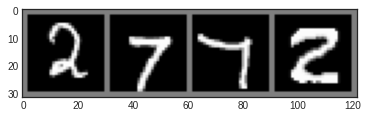

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [ ]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.1218, -0.1267, -0.0516, -0.0684, -0.0019,  0.0600, -0.0006, -0.0095,
         -0.0970,  0.0835]], grad_fn=<AddmmBackward>)


## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [ ]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epochs=2`로 지정

In [ ]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11524193215370178
Epoch: 1, Iter: 200, Loss: 0.11502808403968812
Epoch: 1, Iter: 300, Loss: 0.11471196281909943
Epoch: 1, Iter: 400, Loss: 0.1144309709072113
Epoch: 2, Iter: 100, Loss: 0.11366398525238038
Epoch: 2, Iter: 200, Loss: 0.11289029490947723
Epoch: 2, Iter: 300, Loss: 0.1113925654888153
Epoch: 2, Iter: 400, Loss: 0.10825728416442872


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7fd73ce80518>

## 모델 테스트

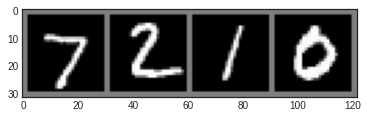

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 2, 1, 7, 2, 0, 4, 0, 2, 2, 0, 1, 0, 2, 2, 2, 4, 7, 6, 2, 2,
        4, 0, 7, 4, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 7, 4, 6, 2, 2, 2, 2,
        2, 2, 6, 2, 0, 0, 2, 0, 2, 1, 4, 1, 7, 2, 2, 2, 2, 1, 2, 4, 2, 0, 7, 0,
        2, 2, 1, 7, 3, 2, 1, 7, 7, 6, 2, 7, 2, 2, 7, 2, 6, 1, 3, 6, 2, 2, 2, 2,
        1, 2, 6, 2, 2, 0, 0, 2, 2, 2, 2, 1, 9, 2, 2, 1, 3, 2, 2, 2, 2, 4, 2, 2,
        2, 6, 7, 6, 7, 2, 0, 0])


In [ ]:
print(''.join('{}\t'.format(str(predicted[j].numpy()) for j in range(4))))

<generator object <genexpr> at 0x7fd73eaef1a8>	


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

49.42


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

- 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

- 데이터 로드


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- 모델 생성

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)



Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11510637068748474
Epoch: 1, Iter: 200, Loss: 0.11488391995429993
Epoch: 1, Iter: 300, Loss: 0.11455264484882355
Epoch: 1, Iter: 400, Loss: 0.1142082006931305
Epoch: 2, Iter: 100, Loss: 0.11323399865627289
Epoch: 2, Iter: 200, Loss: 0.11202690064907074
Epoch: 2, Iter: 300, Loss: 0.1094776885509491
Epoch: 2, Iter: 400, Loss: 0.10289912343025208


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

62.86
